# Road Lane Detection Using Hough Transform

### Importing Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

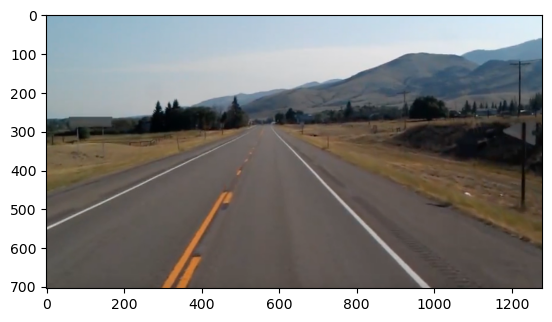

In [2]:
img = cv2.imread('testHough.jpg', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Smoothing the image

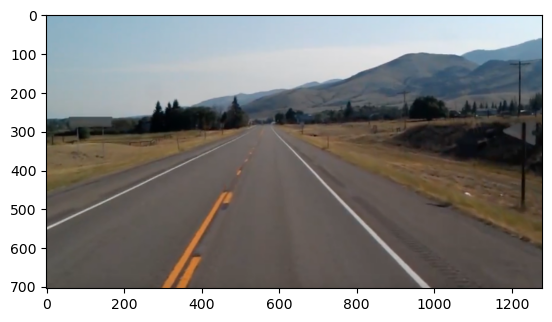

In [3]:
img2 = cv2.medianBlur(img, 3)
plt.imshow(img2)

### Edge Detection

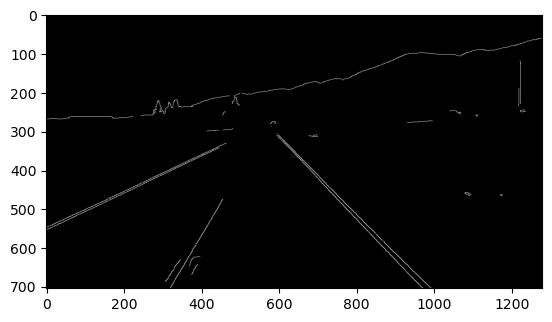

In [4]:
edges = cv2.Canny(img2, 150, 250)
plt.imshow(edges, cmap='gray')

### Region Of Interest

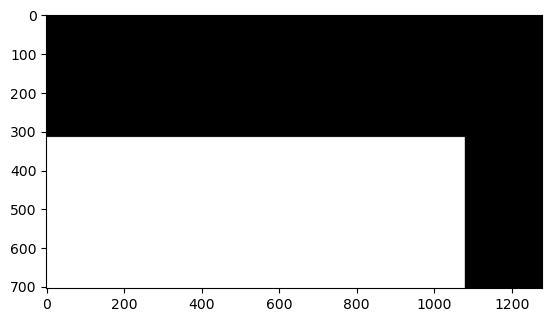

In [5]:
width, length, _ = img.shape
mask = np.zeros(img.shape[:2], dtype="uint8")
cv2.rectangle(mask, (0, int(3.6*width/8)), (length-200, width), 255, -1)
plt.imshow(mask, cmap='gray')

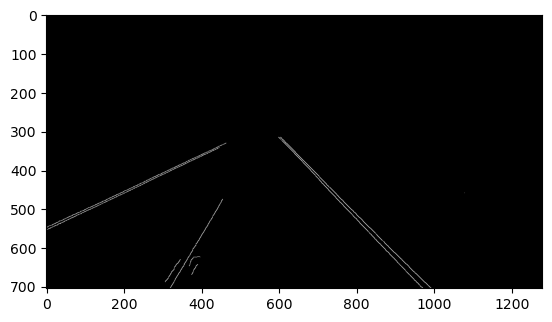

In [6]:
edges_masked = cv2.bitwise_and(edges, edges, mask=mask)
plt.imshow(edges_masked, cmap='gray')

### Accumulation into (ρ, θ)-space using Hough transform

Custom Implementation:

In [7]:
def hough_transform_line(img, edge_image, num_rhos=180, num_thetas=180, t_count=300):
    img_copy = img.copy()
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    
    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
  
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
  
    accumulator = np.zeros((len(rhos), len(thetas)))
  
    for y in range(edge_height):
        for x in range(edge_width):
            if edge_image[y][x] != 0:
                edge_point = [y - edge_height_half, x - edge_width_half]
                for theta_idx in range(len(thetas)):
                    rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
                    rho_idx = np.argmin(np.abs(rhos - rho))
                    accumulator[rho_idx][theta_idx] += 1
    best_thetas = np.zeros((20))
    best_counts = np.zeros((20))
    count = 0
    for x in range(accumulator.shape[0]):
        for y in range(accumulator.shape[1]):
            if accumulator[x][y] > t_count :
                rho = rhos[x]
                theta = thetas[y]
                closeness_theta = np.isclose(theta, best_thetas, atol = 20.0)
                z = 0
                e = 0
                for i in range(closeness_theta.size):
                    if closeness_theta[i] == True:
                        e = i
                        z = 1
                        break
                if z == 1:
                    if accumulator[x][y] > best_counts[e]:
                        best_counts[e] = accumulator[x][y]                
                else:
                    best_thetas[count] = theta
                    best_counts[count] = accumulator[x][y]
                    count+=1
                 
    for x in range(accumulator.shape[0]):
        for y in range(accumulator.shape[1]):
            if accumulator[x][y] > t_count :
                rho = rhos[x]
                theta = thetas[y]
                if accumulator[x][y] not in list(best_counts) or  accumulator[x][y]==0:
                    continue
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                x0 = (a * rho) + edge_width_half
                y0 = (b * rho) + edge_height_half
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                
                cv2.line(img_copy, (x1,y1), (x2,y2), (0,255,0), 2)

    return img_copy, accumulator

In [8]:
img_copy, accumulator = hough_transform_line(img2, edges_masked)

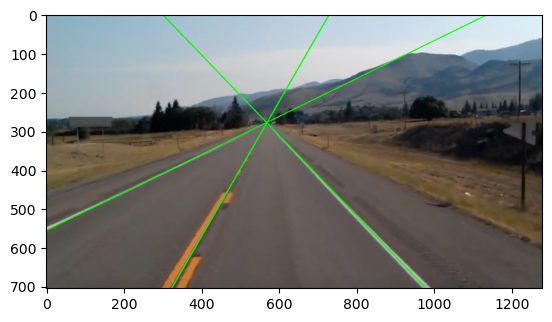

In [9]:
plt.imshow(img_copy)

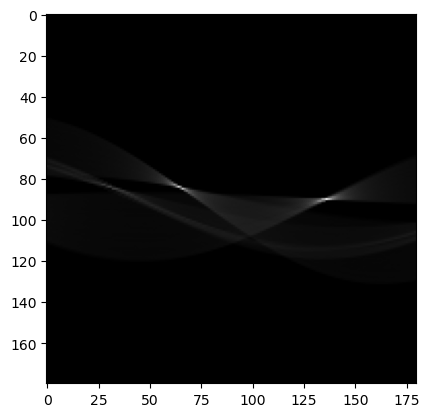

In [10]:
plt.imshow(accumulator, cmap='gray')

### Refining Coordinates and HT Post-Processing

In [11]:
import itertools
from scipy.spatial.distance import pdist

In [12]:
N = 10

# Convert it into a 1D array
a_1d = accumulator.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-N:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, accumulator.shape)

# Check that we got the largest values.
points = []
for x, y, in zip(x_idx, y_idx):
    #print(x, y, accumulator[x][y])
    points.insert(0,[x, y])

points = np.array(points)

In [13]:
Npoints = 3
# making up some data:
# finding row indices of all combinations:
c = [list(x) for x in itertools.combinations(range(len(points)), Npoints)]

distances = []
for i in c:    
    distances.append(np.mean(pdist(points[i,:])))
ind = distances.index(max(distances))
rows = c[ind]

High confidence points

In [14]:
points[rows]

array([[ 85,  66],
       [ 90, 138],
       [ 83,  62]], dtype=int64)

In [15]:
for x in range(accumulator.shape[0]):
    for y in range(accumulator.shape[1]):
        if [x,y] not in points[rows]:
            accumulator[x][y] = 0

Accumulator post non-max suppression

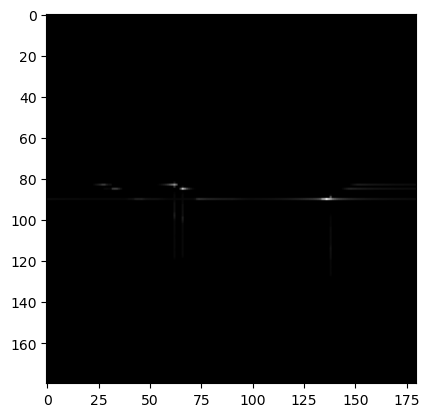

In [16]:
plt.imshow(accumulator, cmap='gray')

In [17]:
def hough_apply_line(img, edge_image, accumulator, num_rhos=180, num_thetas=180, t_count=500):
    
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    
    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
    
    for x in range(accumulator.shape[0]):
        for y in range(accumulator.shape[1]):
            if accumulator[x][y] > t_count:
                rho = rhos[x]
                theta = thetas[y]
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                x0 = (a * rho) + edge_width_half
                y0 = (b * rho) + edge_height_half
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                cv2.line(img, (x1,y1), (x2,y2), (0,255,0), 2)
    return img

In [18]:
img_copy2 = img2.copy()
img3 = hough_apply_line(img_copy2, edges_masked, accumulator)

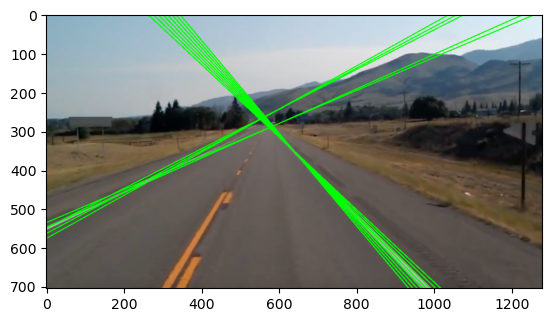

In [19]:
plt.imshow(img3)